# PROJET 9 : PREDISEZ LA DEMANDE EN ELECTRICITE

In [2]:
#import modules
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import math
from sklearn import decomposition
from sklearn import preprocessing
import re
from scipy.stats import t, shapiro
import statsmodels

pd.set_option('display.max_rows', 170)

## Import, nettoyage et traitement des données

### 1 ) Import des données d'énergie

In [2]:
#import donnéees énergie
data = pd.read_csv('donnees/data_energie.csv', sep = ';', parse_dates=[0], index_col="Mois")
data.index.name = None
data.head()

,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,974,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [3]:
#on selectionne la colonne 'consommation totale' et les données pour tout le territoire français*
data = data[data['Territoire'] == 'France']
data = data[['Consommation totale']]
data.rename(columns={'Consommation totale': "conso"}, inplace = True)

In [4]:
#nombre de periodes
n = len(data)
print('nombre périodes (mois) : ', n)
print('Début : ', data.index[0].month,data.index[0].year)
print('Fin : ', data.index[-1].month,data.index[-1].year)

nombre périodes (mois) :  104
Début :  1 2012
Fin :  8 2020


In [5]:
#description des données
data.describe()

,conso
count,104.000000
mean,39752.807692
std,7146.858961
min,30719.000000
25%,33347.750000
50%,36980.500000
75%,45047.500000
max,57406.000000


Pas de valeurs incohérentes a priori

In [6]:
#valeurs manquantes éventuelles
data[data.isnull().any(axis=1)]

,conso


Aucune valeur manquante

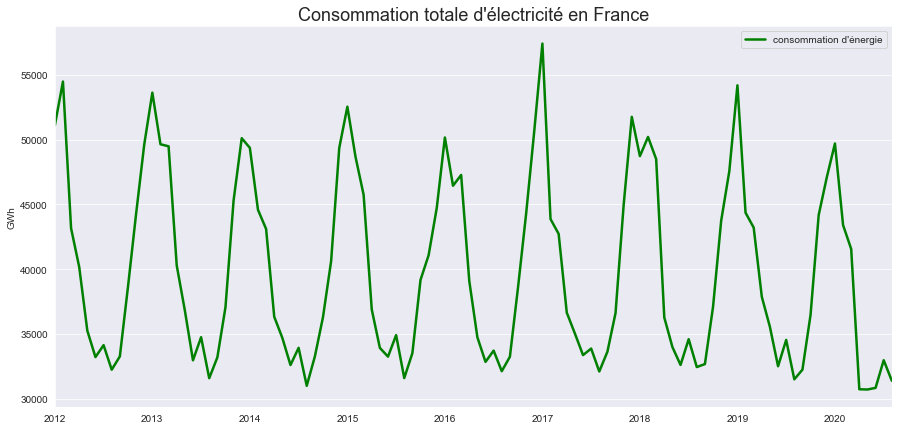

In [7]:
#plot de la consommation totale
sns.set_style("darkgrid")
plot = data.plot(y="conso", figsize=(15,7), c = 'g', lw= 2.5)
plot.xaxis.grid(False)
plt.title('Consommation totale d\'électricité en France', size = 18)
plt.ylabel('GWh')
plt.legend(['consommation d\'énergie'])
plt.show()

### 2 ) Import des données de température

Les données de température représentent la somme des écarts à une température de réference (ici 18°C) sur le mois

In [8]:
#import données température
temperature = pd.read_csv('donnees/data_temperature.csv', sep = ';', index_col = 0, decimal=",")
temperature = temperature.sort_index()
temperature

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5
2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3
2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0,2040.6
2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9,2002.2
2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3,1989.0
2020,339.0,249.6,268.6,81.4,65.7,20.6,0.0,0.0,0.0,0.0,0.0,0.0,1024.9


In [9]:
#describe
temperature.describe()

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,373.466667,337.355556,269.011111,164.522222,92.888889,22.611111,3.877778,5.311111,35.855556,117.811111,239.000000,302.744444,1964.222222
std,54.021038,73.365304,59.338340,49.072925,30.649121,11.559568,4.593141,5.666225,24.714121,54.242222,96.614919,120.548674,393.207489
min,303.400000,249.600000,201.900000,81.400000,55.900000,8.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1024.900000
25%,336.000000,278.400000,223.900000,135.500000,75.000000,15.800000,0.000000,2.400000,16.000000,99.400000,222.600000,325.900000,1986.200000
50%,364.400000,321.600000,268.600000,168.500000,88.100000,20.600000,1.000000,3.300000,34.300000,122.400000,282.600000,345.900000,2002.200000
75%,404.900000,402.200000,314.300000,209.500000,100.200000,27.500000,6.900000,6.100000,58.000000,154.600000,285.600000,368.200000,2191.500000
max,467.900000,435.900000,376.600000,230.300000,158.400000,43.600000,12.400000,19.300000,71.900000,176.900000,303.900000,390.800000,2424.800000


In [10]:
#on modifie le dataframe pour obtenir une série temporelle

temperature = temperature.iloc[:, :-1] #suppresssion colonne 'Total'

temperature.columns = range(1, 13) #on afficher les mois par leur numero
temperature = temperature.stack() #on fait apparaitre les mois ligne par ligne

#on transforme l'index au format date
temperature.columns = range(1, 13)
year = temperature.index.get_level_values(0).values
month = temperature.index.get_level_values(1).values
temperature.index = pd.PeriodIndex(year=year, month=month, freq='M')

temperature = pd.DataFrame(temperature)
temperature.columns = ['temp']
temperature.head()

,temp
2012-01,336.0
2012-02,435.9
2012-03,201.9
2012-04,230.3
2012-05,83.3


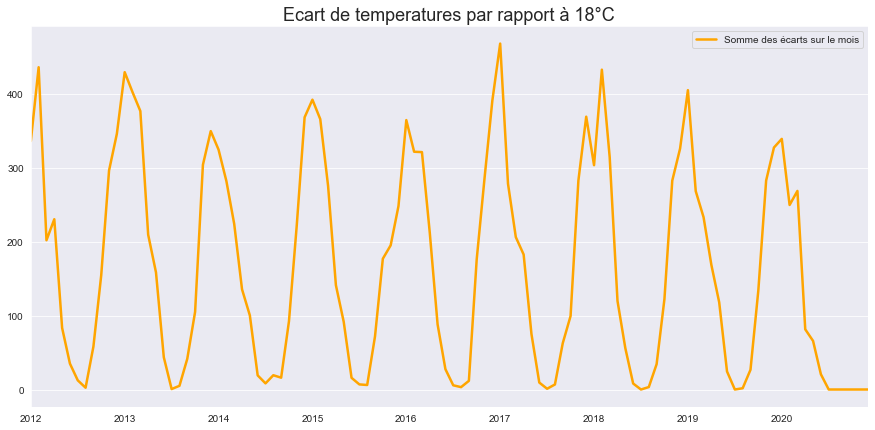

In [11]:
#plot des valeurs de temperature

sns.set_style("darkgrid")
plot = temperature.plot(y="temp", figsize=(15,7), c = 'orange', lw= 2.5)
plot.xaxis.grid(False)
plt.title('Ecart de temperatures par rapport à 18°C', size = 18)
plt.legend(['Somme des écarts sur le mois'])
plt.show()

In [12]:
#on ajoute les valeurs de temperature au df d'énergie
data['temp'] = np.array(temperature[:104]['temp'])
data.head()

,conso,temp
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3


In [13]:
#on supprime les lignes juillet et aout 2020 car pas de valeurs de temperature pour ces 2 derniers mois
data = data.iloc[:-2]
n -= 2

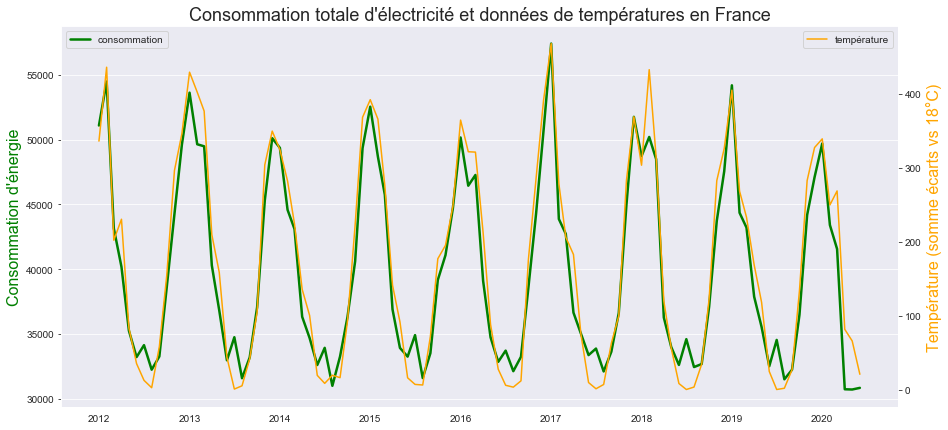

In [14]:
#plot comparaison conso energie et temperatures

x = data.index
fig, ax1 = plt.subplots(figsize=(15,7))

ax2 = ax1.twinx()
ax1.plot(x, data.conso, 'g', lw= 2.5, alpha = 1)
ax2.plot(x, data.temp, 'orange', lw= 1.5, alpha = 1)

ax1.set_ylabel('Consommation d\'énergie', color='g', size = 16)
ax2.set_ylabel('Température (somme écarts vs 18°C)', color='orange', size = 16)

ax1.xaxis.grid(False)
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
plt.title('Consommation totale d\'électricité et données de températures en France',size = 18)
ax1.legend(['consommation'], loc = 2)
ax2.legend(['température'], loc = 1)
plt.show()

# MISSION 1 : correction de la consommation de l'effet température

- On effectue une régression linéaire la consommation d'électricité, avec comme variable explicatrice les données de temperature

In [15]:
#regression linéaire

x = np.array(data['temp']).reshape(-1, 1)
y = data['conso']


from sklearn import linear_model
regression = linear_model.LinearRegression(fit_intercept=True)
regression.fit(x, y)
print(regression)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [16]:
#on affiche les coefficients de la regression
print(regression.intercept_)
print(regression.coef_)

31372.074274183055
[49.20596739]


In [17]:
#correction de la consommation : y_cvt = y corrigé des variations de température
a = regression.intercept_
c = regression.coef_[0] #coeff temperatures

#y_predict : résultat de la regression linéaire
y_predict = regression.predict(x)
data['y_predict'] = y_predict

conso_corrigée = y - ( c * (data['temp'].copy()))
data['conso_corrigée'] = conso_corrigée

C:\Users\artba\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\artba\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [18]:
#Analyse des résidus de la regression, qui correspondent à la conso corrigée
residus = data['conso'] - data['y_predict']
#Test de normalité des résidus
shapiro(residus)

(0.9868101477622986, 0.4105657637119293)

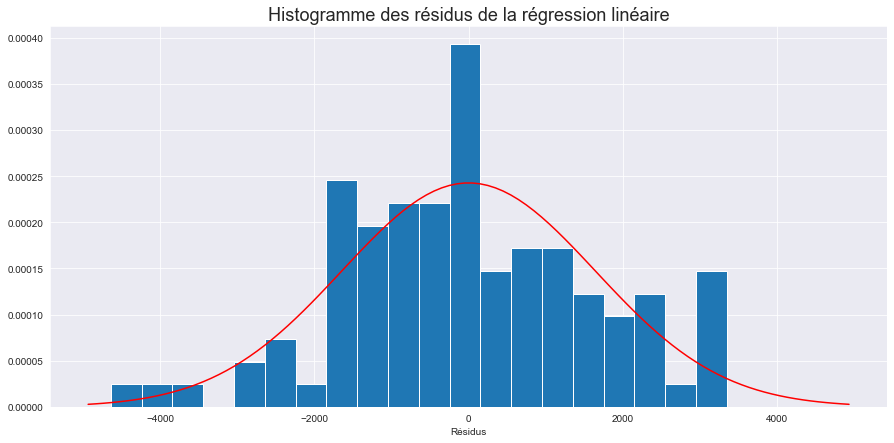

In [19]:
#histogramme des résidus
fig, ax1 = plt.subplots(figsize=(15,7))
plt.hist(residus, density=True, bins = 20)

#distribution gaussienne affichée en rouge
mu = np.mean(residus)
variance = np.var(residus)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma), c = 'r')

plt.xlabel('Résidus')
plt.title('Histogramme des résidus de la régression linéaire', size = 18)
plt.savefig('P9_02_graphiques/hist_residus_regression.png', bbox_inches='tight')
plt.show()

- On ne rejette pas l'hypothèse de normalité des résidus, d'autant plus que l'échantillon est relativement faible

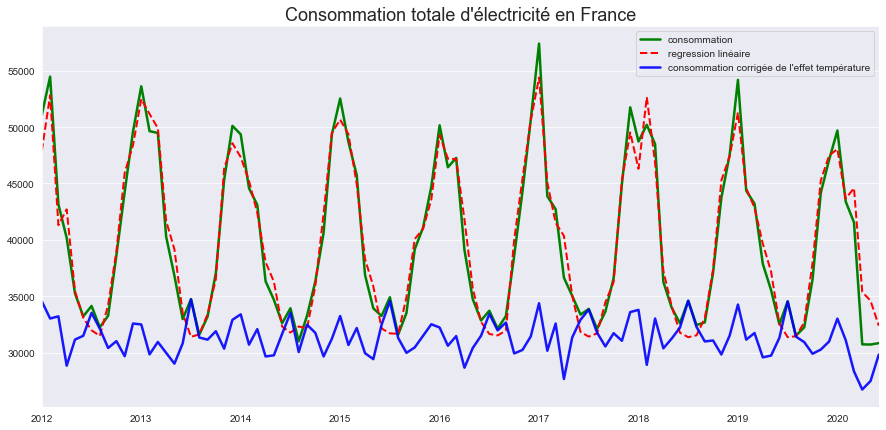

In [20]:
#affichage consommation d'électricité ET consommation corrigé de l'effet température

p1 = data.plot( y= 'conso', c = 'g', lw= 2.5, figsize=(15,7))
p2 = data.y_predict.plot(legend = True, c = 'r',  ls='dashed', lw= 2) #regression lineaire
p3 = conso_corrigée.plot(legend = True, c = 'b', lw= 2.5, alpha = 0.9) #conso corrigée
p1.xaxis.grid(False)
plt.title('Consommation totale d\'électricité en France', size = 18)
plt.legend(['consommation', 'regression linéaire','consommation corrigée de l\'effet température'])
plt.savefig('P9_02_graphiques/graph_Q1.png', bbox_inches='tight')
plt.show()

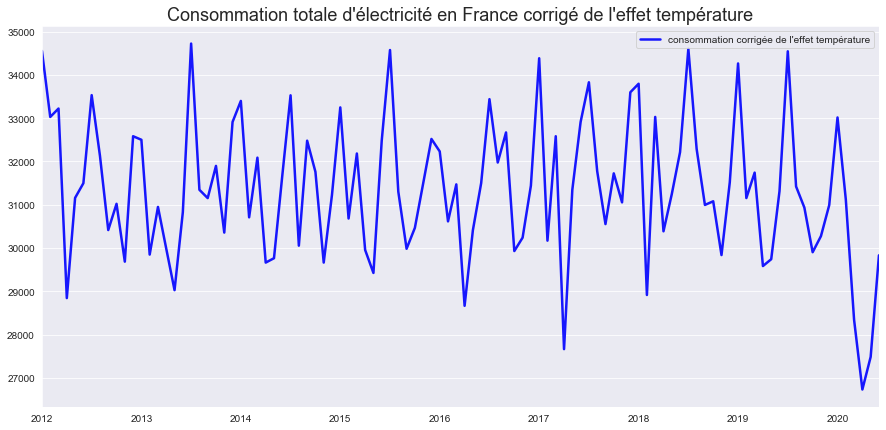

In [21]:
#affichage de la consommation corrigée seule

p1 = conso_corrigée.plot(legend = True, c = 'b', lw= 2.5, figsize=(15,7), alpha = 0.9) #conso corrigée
p1.xaxis.grid(False)
plt.title('Consommation totale d\'électricité en France corrigé de l\'effet température', size = 18)
plt.legend(['consommation corrigée de l\'effet température'])
plt.show()

# MISSION 2 :  désaisonnalisation de la consommation corrigée grâce aux moyennes mobiles

On corrige la série des variations saisonières en utilisant la fonction seasonal_decompose. On peut ainsi séparer le trend, la composante saisonière et la composante résiduelle.

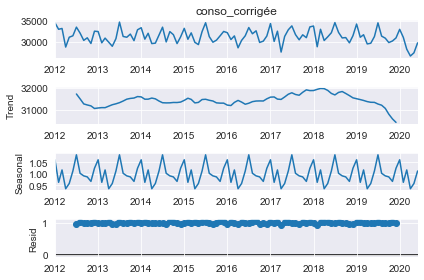

In [22]:
#decompose
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomp_conso = seasonal_decompose(data['conso_corrigée'],  model='multiplicative')
decomp_conso.plot()
plt.show()

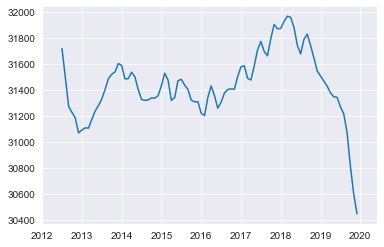

In [23]:
decomp_conso.trend.plot()
plt.show()

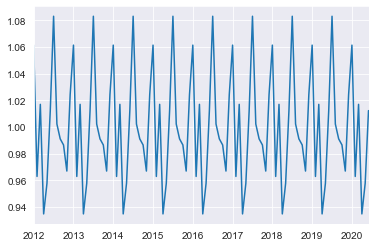

In [24]:
decomp_conso.seasonal.plot()
plt.show()

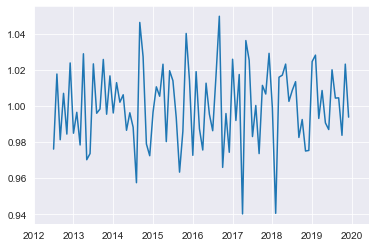

In [25]:
decomp_conso.resid.plot()
plt.show()

- On retire la composante saisonnière (obtenue avec les moyennes mobiles) de notre série conso_corrigée

In [26]:
#on retire la composante saisonnière (division ici car on a utilisé un modèle multiplicatif)
conso_corrigée_CVS = conso_corrigée / decomp_conso.seasonal 
data['conso_corrigée_CVS'] = conso_corrigée_CVS

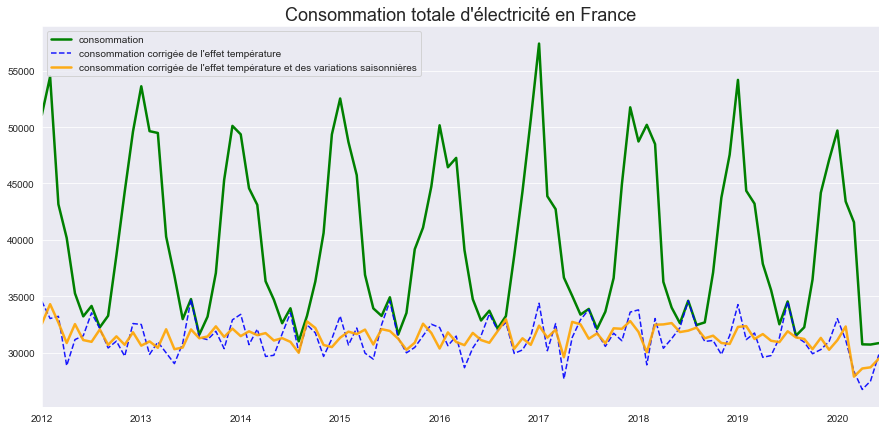

In [27]:
#affichageconsommation d'électricité ET consommation corrigé de l'effet température ET corrigée des variations saisonnières

p1 = data.plot( y= 'conso', c = 'g', lw= 2.5, figsize=(15,7))
p2 = conso_corrigée.plot(legend = True, c = 'b', lw= 1.5, alpha = 0.9, ls = 'dashed') #conso corrigée
p3 = conso_corrigée_CVS.plot(legend = True, c = 'orange', lw= 2.5, alpha = 0.9) #conso_corrigée_CVS
p1.xaxis.grid(False)
plt.title('Consommation totale d\'électricité en France', size = 18)
plt.legend(['consommation', 'consommation corrigée de l\'effet température','consommation corrigée de l\'effet température et des variations saisonnières'])
plt.show()

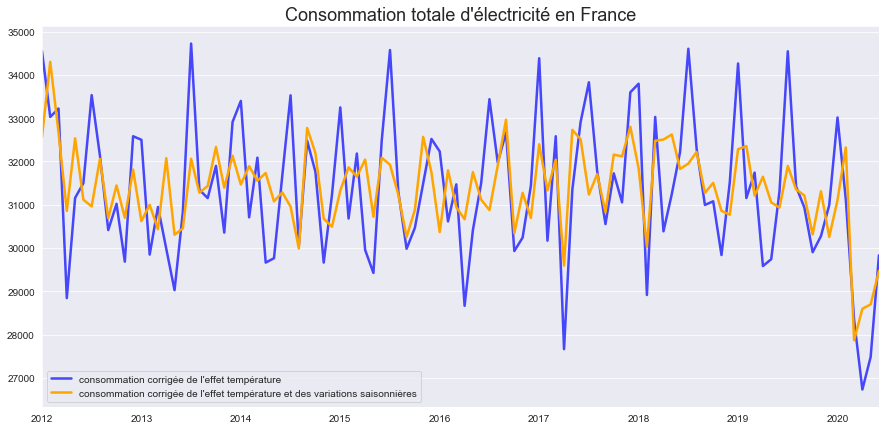

In [28]:
# affichage consommation corrigé de l'effet température ET corrigée des variations saisonnières

p1 = conso_corrigée.plot(legend = True, c = 'b', lw= 2.5, alpha = 0.7, figsize=(15,7)) #conso corrigée
p2 = conso_corrigée_CVS.plot(legend = True, c = 'orange', lw= 2.5, alpha = 1) #conso_corrigée_CVS
p1.xaxis.grid(False)
plt.title('Consommation totale d\'électricité en France', size = 18)
plt.legend(['consommation corrigée de l\'effet température','consommation corrigée de l\'effet température et des variations saisonnières'])
plt.savefig('P9_02_graphiques/graph_Q2.png', bbox_inches='tight')
plt.show()

# MISSION 3 :  Prévision de la consommation

## A ) Méthode de  Holt-Winters

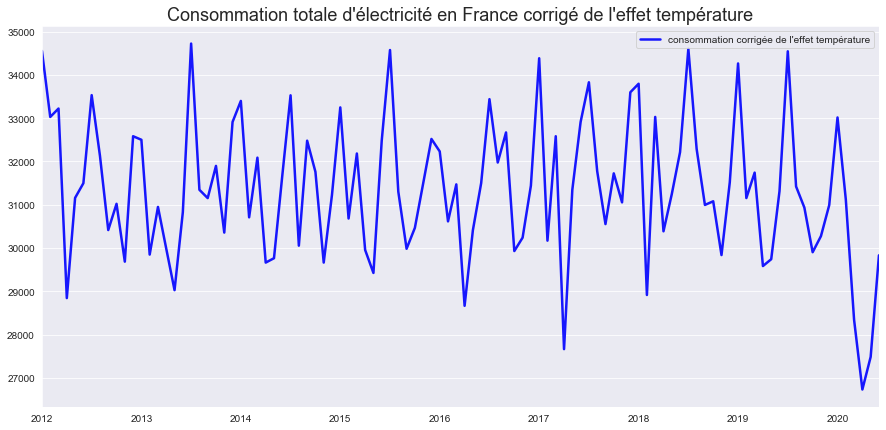

In [29]:
#on part de notre consommation corrigée de l'effet température
p1 = conso_corrigée.plot(legend = True, c = 'b', lw= 2.5, figsize=(15,7), alpha = 0.9) #conso corrigée
p1.xaxis.grid(False)
plt.title('Consommation totale d\'électricité en France corrigé de l\'effet température', size = 18)
plt.legend(['consommation corrigée de l\'effet température'])
plt.show()

In [30]:
#méthode de Holt-Winters :

from statsmodels.tsa.api import ExponentialSmoothing
hw = ExponentialSmoothing(np.asarray(conso_corrigée), seasonal_periods=12, trend='mul', seasonal='mul').fit()
conso_prev_HW = hw.forecast(12)

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [31]:
#creation d'un df contenant la consommation corrigée et la prévision sur une seule colonne
data_prev = pd.DataFrame(index = pd.date_range(data.index[len(data) - 1], periods=12, freq='M'), data = conso_prev_HW)
data_prev = pd.concat([data['conso_corrigée'], data_prev])

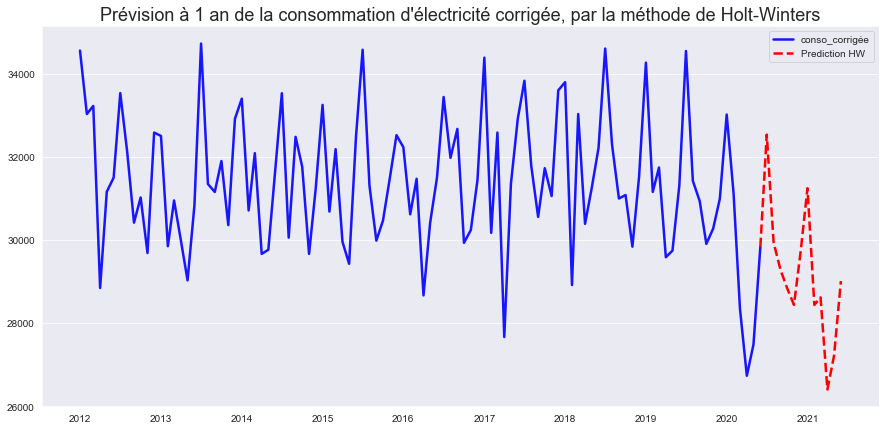

In [32]:
#affichage prévision

fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev.mask(data_prev.apply(lambda x: x.index > '2020-06-01'))[0], label='conso_corrigée', c = 'b', lw= 2.5, alpha = 0.9)
plt.plot(data_prev.mask(data_prev.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction HW', c = 'red', lw= 2.5, ls = 'dashed')
ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision à 1 an de la consommation d\'électricité corrigée, par la méthode de Holt-Winters', size = 18)
plt.show()

In [33]:
# méthode de Holt-Winters en ne prenant en compte que la conso jusqu'à fevrier 2020 (PRE-COVID)

hw2 = ExponentialSmoothing(np.asarray(conso_corrigée[:-4]), seasonal_periods=12, trend='mul', seasonal='mul').fit()
conso_prev_HW_2 = hw2.forecast(16)

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


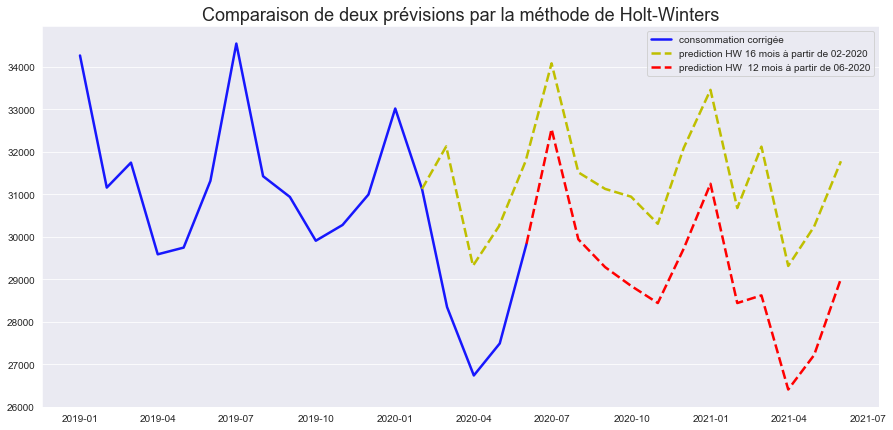

In [34]:
#affichage prévision

data_prev2 = pd.DataFrame(index = pd.date_range(data.index[len(data) - 5], periods=16, freq='M'), data = conso_prev_HW_2)
data_prev2 = pd.concat([data['conso_corrigée'][:-4], data_prev2])

fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev[-30:-12][0], c = 'b', lw= 2.5, alpha = 0.9, label='consommation corrigée')
plt.plot(data_prev2.mask(data_prev2.apply(lambda x: x.index < '2020-02-01'))[0],label='prediction HW 16 mois à partir de 02-2020', c = 'y', lw= 2.5, ls = 'dashed')
plt.plot(data_prev.mask(data_prev.apply(lambda x: x.index < '2020-06-01'))[0],label='prediction HW  12 mois à partir de 06-2020', c = 'red', lw= 2.5, ls = 'dashed')
ax1.xaxis.grid(False)
plt.legend()
plt.title('Comparaison de deux prévisions par la méthode de Holt-Winters', size = 18)
plt.savefig('P9_02_graphiques/graph_Q3_HW.png', bbox_inches='tight')
plt.show()

In [35]:
#ANALYSE A POSTERIORI DE LA METHODE HW SUR UNE SERIE TRONQUEE 

#split des données : train et test
conso_train = conso_corrigée[conso_corrigée.index < '2019-01-01']
conso_a_prevoir = conso_corrigée[conso_corrigée.index >= '2019-01-01']


hw_3 = ExponentialSmoothing(np.asarray(conso_train), seasonal_periods=12, trend='mul', seasonal='mul').fit()
conso_prev_HW_3 = hw.forecast(18)

#RMSE
rmse = np.sqrt(((conso_a_prevoir-conso_prev_HW_3)**2).mean())
print('RMSE: ', rmse)
mape=(np.abs(1-conso_prev_HW_3/conso_a_prevoir)).mean()*100
print('MAPE: ', mape)

RMSE:  2096.6086976814263
MAPE:  5.987032302136237


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


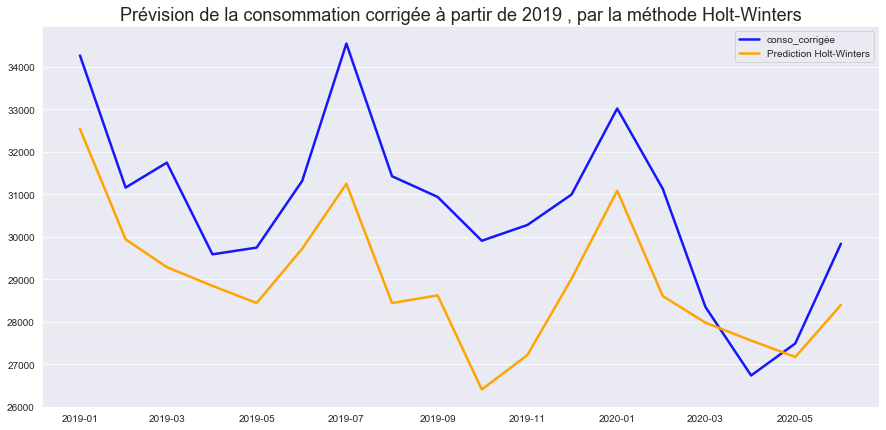

In [36]:
#affichage prévision 

data_prev3 = pd.DataFrame(index = pd.date_range(data.index[len(data) - 18], periods=18, freq='MS'), data = conso_prev_HW_3)
data_prev3 = pd.concat([data['conso_corrigée'][:-18], data_prev3])


fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(conso_a_prevoir, label='conso_corrigée', c = 'b', lw= 2.5, alpha = 0.9)
plt.plot(data_prev3.mask(data_prev3.apply(lambda x: x.index < '2019-01-01'))[0],label='Prediction Holt-Winters', c = 'orange', lw= 2.5)

ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision de la consommation corrigée à partir de 2019 , par la méthode Holt-Winters', size = 18)
plt.show()

- la méthode de Holt Winters n'est pas satisfaisante pour des prévisions à long terme

## B ) Méthode SARIMA

### Autocorrélations

In [37]:
#definition fonction plot ACF

def plot_sortie_acf( y_acf, y_len, pacf=False, series_title = ''):
    "représentation de la sortie ACF"
    
    title = 'Autocorrélogramme simple'
    if pacf == True:
        y_acf = y_acf[1:]
        title = 'Autocorrélogramme partiel'
    fig, ax1 = plt.subplots(figsize=(15,7))
    plt.bar(range(len(y_acf)), y_acf, width = 0.2)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    if pacf == True:
        plt.ylabel('PACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='r', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='r', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    if series_title != '':
        plt.title(title + '  -  ' + series_title , size = 18)
    else:
        plt.title(title, size = 18)
    plt.show()
    return

### Autocorrélation simple de la conso_corrigée

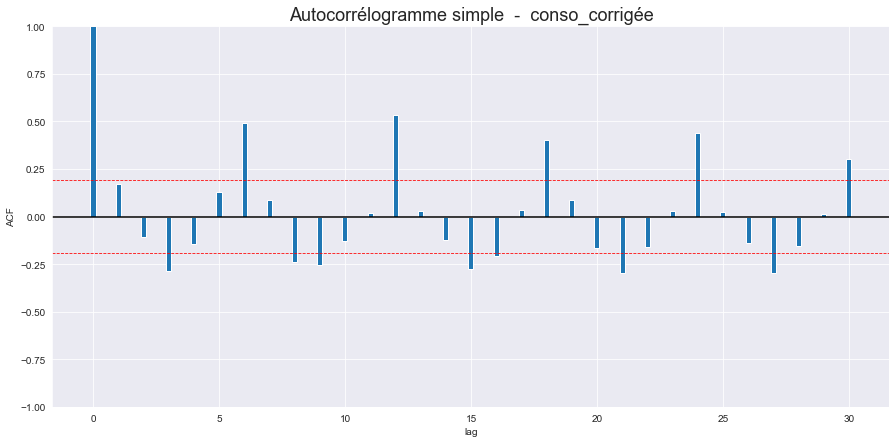

In [38]:
from statsmodels.tsa.stattools import acf, pacf

plot_sortie_acf(acf(conso_corrigée, fft=False, nlags = 30), n, pacf = False, series_title = 'conso_corrigée')

- On note une décroissance lente des autocorrélations, notamment les multiples de 6 et de 3

- On essaie de différentier la série pour obtenir une série stationnaire. On applique  $(I−B^{1})$ .

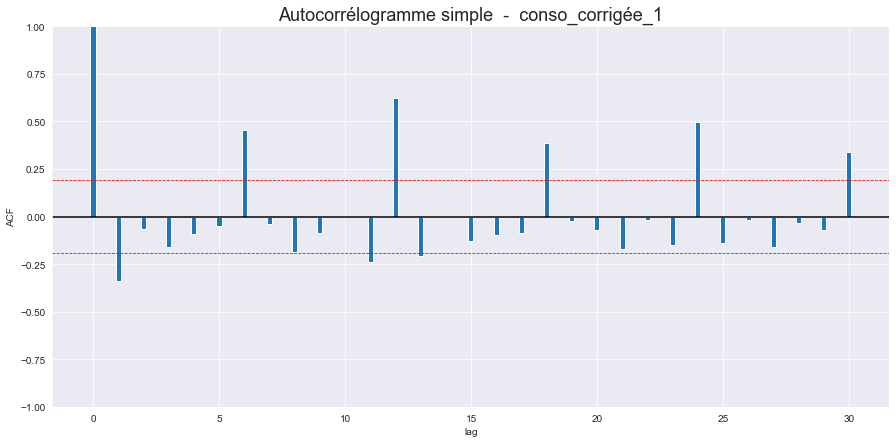

In [39]:
#Différenciation d'ordre 1
conso_corrigée_1 = conso_corrigée - conso_corrigée.shift(1)

plot_sortie_acf(acf(conso_corrigée_1[1:], fft=False, nlags = 30), n, pacf = False, series_title = 'conso_corrigée_1')

- La décroissance est toujours lente pour les multiples de 6 et de 12

- On essaie d'effectuer une différenciation saisonnière de période 12 (ou 6?). On applique  $(I−B^{12})$ .

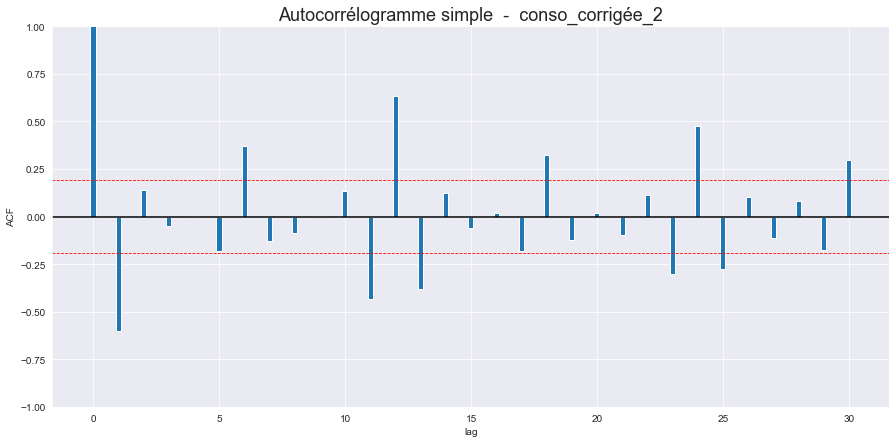

In [40]:
#Différenciation d'ordre 2
conso_corrigée_2 = conso_corrigée_1 - conso_corrigée_1.shift(1)

plot_sortie_acf(acf(conso_corrigée_2[2:], fft=False, nlags = 30), n, pacf = False, series_title = 'conso_corrigée_2')

- On ne retient pas la différenciation d'ordre 2

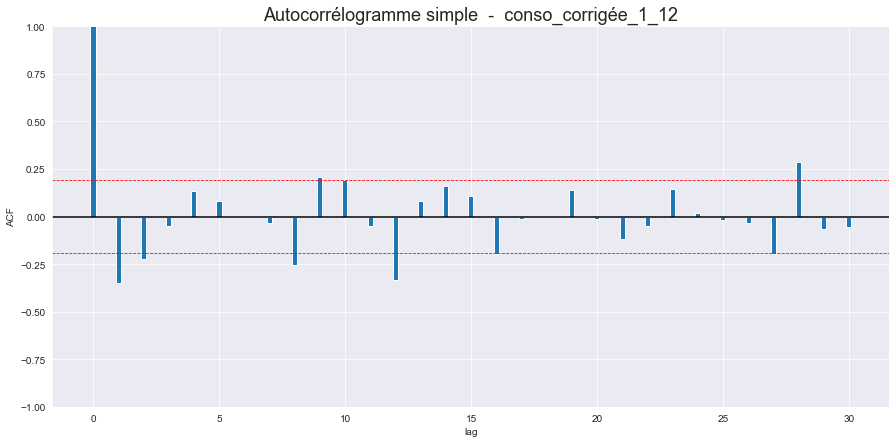

In [41]:
#differentiation d'ordre 12
conso_corrigée_1_12 = conso_corrigée_1 - conso_corrigée_1.shift(12)

plot_sortie_acf(acf(conso_corrigée_1_12[13:], fft=False, nlags = 30), n, pacf = False, series_title = 'conso_corrigée_1_12')

- Décroissance forte vers 0 : le processus différencié $(I−B^{1})$ $(I−B^{12})$ * **conso_corrigée** est stationnaire

- On soupconne néanmoins une sur-différentiation, on affiche donc l'ACF de la série différentiée à l'ordre 12, mais SANS la différentiation d'ordre 1

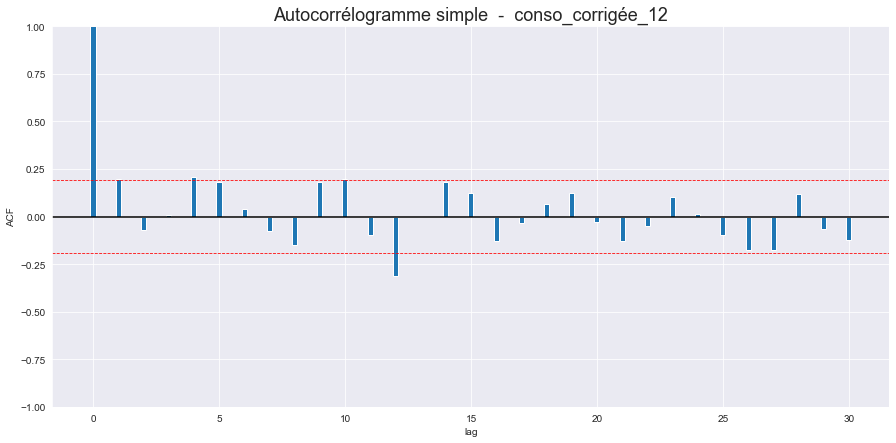

In [42]:
# differentiation d'ordre 12 SANS ORDRE 1
conso_corrigée_12 = conso_corrigée - conso_corrigée.shift(12)

plot_sortie_acf(acf(conso_corrigée_12[12:], fft=False, nlags = 30), n, pacf = False, series_title = 'conso_corrigée_12')

### Autocorrélogramme partiel

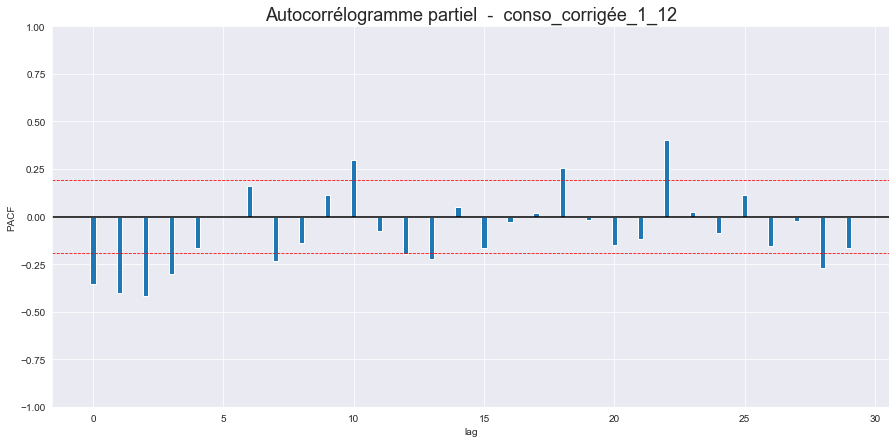

In [43]:
#acf partiel sur la conso_corrigée stationnarisé (ordre 1 + ordre 12)
plot_sortie_acf(pacf(conso_corrigée_1_12[13:], nlags = 30), n, pacf = True, series_title = 'conso_corrigée_1_12')

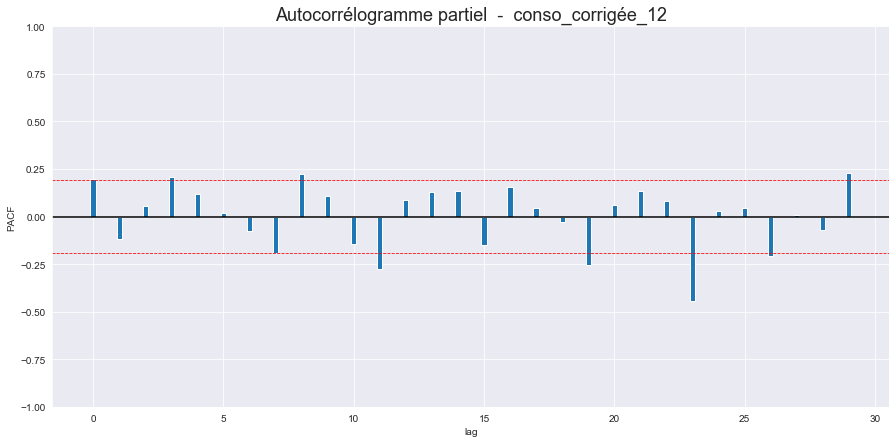

In [44]:
#acf partiel sur la conso_corrigée stationnarisé (ordre 12)
plot_sortie_acf(pacf(conso_corrigée_12[12:], nlags = 30), n, pacf = True, series_title = 'conso_corrigée_12')

## TESTS DES MODELES

### MODELE A :  $SARIMA(1,0,1)(1,0,1)_{12}$

$$(I−φ_{1}B)(I−φ′_{1}B^{12})(I−B^{12}) * conso.corrigée(t) = (I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [72]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

conso_corrigée.index = pd.DatetimeIndex(conso_corrigée.index.values, #on precise la frequence estimée de la série pour eviter un Warning pdt les modelisations
                               freq=conso_corrigée.index.inferred_freq)

model1 = SARIMAX(conso_corrigée, order=(1,0,1), seasonal_order=(1,1,1,12), return_df = False)
results1 = model1.fit()
print(results1.summary())

print('\n\n\n Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('   {}    :    {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -772.456
Date:                            Mon, 09 Nov 2020   AIC                           1554.912
Time:                                    11:20:55   BIC                           1567.411
Sample:                                01-01-2012   HQIC                          1559.952
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4027      0.672     -0.599      0.549      -1.720       0.915
ma.L1          0.4584      0.669   

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [ ]:
#MODELE A 2
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(conso_corrigée, order=(1,0,1), seasonal_order=(1,0,1,12), return_df = False)
results1 = model1.fit()
print(results1.summary())

print('\n\n\n Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('   {}    :    {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

-
-

**ANALYSE:**

- Un des paramètres du modèles n'est pas significatif

### MODELE B : 
$SARIMA(1,0,1)(1,0,0)_{12}$

$$(I−φ_{1}B)(I−φ′_{1}B^{12}) * conso.corrigée(t) = (I+θ_{1}B)ε_{t} $$

In [46]:
model2 = SARIMAX(conso_corrigée[1:], order=(1,0,1), seasonal_order=(1,0,0,12))
results2 = model2.fit()
print(results2.summary())

print('\n\n\n Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('   {}    :    {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  101
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -869.416
Date:                             Mon, 09 Nov 2020   AIC                           1746.833
Time:                                     09:27:37   BIC                           1757.293
Sample:                                 02-01-2012   HQIC                          1751.068
                                      - 06-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.42e-06   1.35e+05      0.000       1.000       1.000
ma.L1         -0.9238      

-
-

**ANALYSE:**

- Tous les paramètres du modèles sont significatifs

- pvalue du test de Ljung-box légèrement <5%, on ne peut pas valider l'hyp H0 de blancheur du residu au seuil 5% mais suffisamment proche

- On ne rejette pas l'hypothèse de normalité des résidus (JB > 5%)

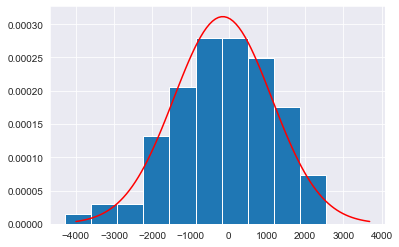

In [47]:
plt.hist(results2.resid[1:], density = True, bins = 10)
mu = np.mean(results2.resid[1:])
variance = np.var(results2.resid[1:])
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma), c = 'r')

plt.show()

## Prévision à l'aide du modèle SARIMA

In [48]:
#prevision
pred_model2 = results2.get_forecast(12)
pred = pred_model2.predicted_mean

#intervalle de confiance
conf_int = pred_model2.conf_int(alpha=0.05)
pred_l = conf_int.iloc[:,0] #borne inf intervalle de confiance
pred_u = conf_int.iloc[:,1] #borne sup intervalle de confiance

#creation d'un df regroupant une seule série avec la conso et la prévision

last_date = data.index[len(data)-1] 
last_date = datetime.date(last_date.year, last_date.month + 1, last_date.day) #dernière date des données / début prevision
date_predict = datetime.date(last_date.year + 1, last_date.month - 1, last_date.day) # date de fin de la prevision

data_prev_sarima = pd.DataFrame(index = pd.date_range(last_date, date_predict , freq='MS'), data = pred)
data_prev_sarima = pd.concat([data['conso_corrigée'], data_prev_sarima])

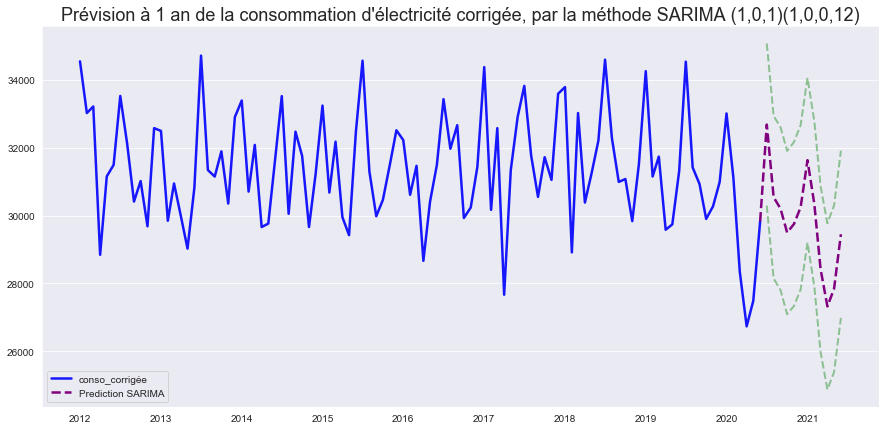

In [49]:
#affichage prévision
fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev_sarima.mask(data_prev_sarima.apply(lambda x: x.index > '2020-06-01'))[0], label='conso_corrigée', c = 'b', lw= 2.5, alpha = 0.9)
plt.plot(data_prev_sarima.mask(data_prev_sarima.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction SARIMA', c = 'purple', lw= 2.5, ls = 'dashed')
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_l, color='g', lw= 2, ls = 'dashed', alpha = 0.4)
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_u, color='g', lw= 2, ls = 'dashed', alpha = 0.4)
ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision à 1 an de la consommation d\'électricité corrigée, par la méthode SARIMA (1,0,1)(1,0,0,12)', size = 18)
plt.savefig('P9_02_graphiques/graph_Q3_SARIMA.png', bbox_inches='tight')
plt.show()

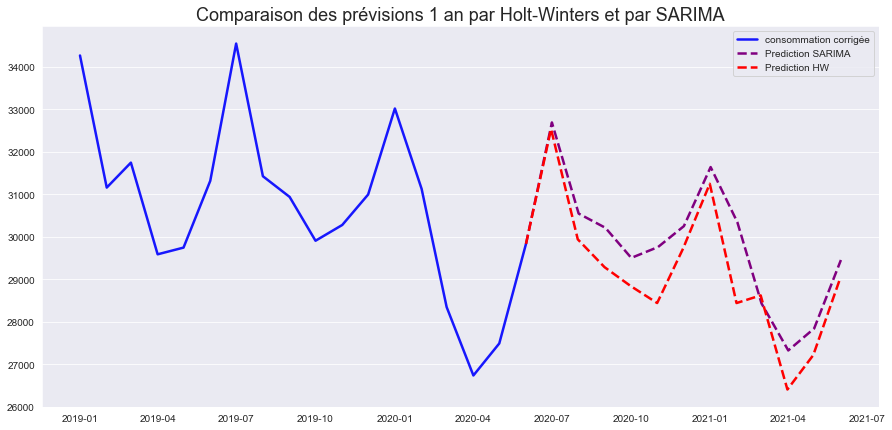

In [50]:
#COMPARAISON entre la méthode Halt-Winters et la méthode SARIMA

fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev[-30:-12][0], c = 'b', lw= 2.5, alpha = 0.9, label='consommation corrigée')
plt.plot(data_prev_sarima.mask(data_prev_sarima.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction SARIMA', c = 'purple', lw= 2.5, ls = 'dashed')
plt.plot(data_prev.mask(data_prev.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction HW', c = 'red', lw= 2.5, ls = 'dashed')
ax1.xaxis.grid(False)
plt.legend()
plt.title('Comparaison des prévisions 1 an par Holt-Winters et par SARIMA', size = 18)
plt.show()

###  SARIMA sur la série PRE-COVID

In [51]:
model2 = SARIMAX(conso_corrigée[:-4], order=(1,0,1), seasonal_order=(1,0,0,12))
results2 = model2.fit()
print(results2.summary())

print('\n\n\n Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('   {}    :    {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   98
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -836.531
Date:                             Mon, 09 Nov 2020   AIC                           1681.061
Time:                                     09:27:39   BIC                           1691.401
Sample:                                 01-01-2012   HQIC                          1685.244
                                      - 02-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   8.39e-06   1.19e+05      0.000       1.000       1.000
ma.L1         -0.9944      

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [52]:
#PREVISION à 16 mois

#prevision
pred_model2 = results2.get_forecast(16)
pred = pred_model2.predicted_mean

#intervalle de confiance
conf_int = pred_model2.conf_int(alpha=0.05)
pred_l = conf_int.iloc[:,0] #borne inf intervalle de confiance
pred_u = conf_int.iloc[:,1] #borne sup intervalle de confiance

#creation d'un df regroupant une seule série avec la conso et la prévision

last_date = data.index[len(data)-1] 
last_date = datetime.date(last_date.year, last_date.month -3, last_date.day) #dernière date des données / début prevision
date_predict = datetime.date(last_date.year + 1, last_date.month + 3, last_date.day) # date de fin de la prevision

data_prev_sarima_2 = pd.DataFrame(index = pd.date_range(last_date, date_predict , freq='MS'), data = pred)
data_prev_sarima_2 = pd.concat([data['conso_corrigée'][:-4], data_prev_sarima_2])

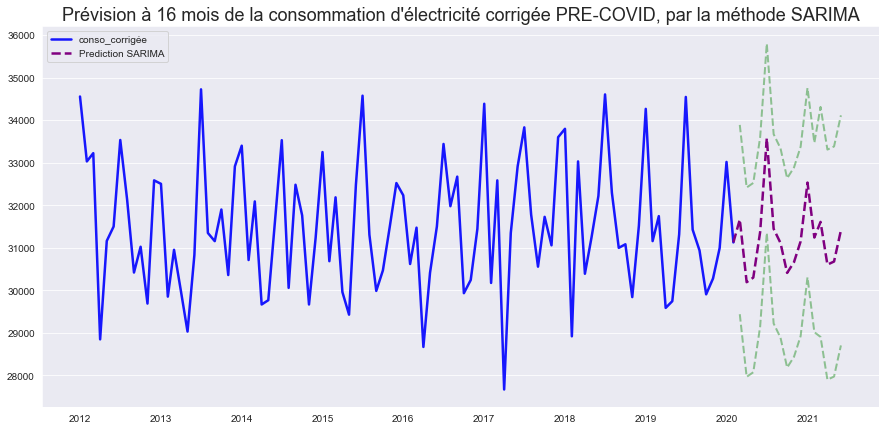

In [53]:
#affichage prévision 16 mois
fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev_sarima_2.mask(data_prev_sarima_2.apply(lambda x: x.index > '2020-02-01'))[0], label='conso_corrigée', c = 'b', lw= 2.5, alpha = 0.9)
plt.plot(data_prev_sarima_2.mask(data_prev_sarima_2.apply(lambda x: x.index < '2020-02-01'))[0],label='Prediction SARIMA', c = 'purple', lw= 2.5, ls = 'dashed')
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_l, color='g', lw= 2, ls = 'dashed', alpha = 0.4)
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_u, color='g', lw= 2, ls = 'dashed', alpha = 0.4)
ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision à 16 mois de la consommation d\'électricité corrigée PRE-COVID, par la méthode SARIMA', size = 18)
plt.show()

## Choix du meilleur modèle SARIMA en minimisant l'AIC

In [54]:
#Modele trouvé en recherchant manuellement le meilleur parametrage
model3 = SARIMAX(conso_corrigée, order=(2,0,0), seasonal_order=(1,0,1,12))
results3 = model3.fit()
print(results3.summary())

print('\n\n\n Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('   {}    :    {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  102
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -877.357
Date:                              Mon, 09 Nov 2020   AIC                           1764.714
Time:                                      09:27:40   BIC                           1777.839
Sample:                                  01-01-2012   HQIC                          1770.029
                                       - 06-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5482      0.099      5.529      0.000       0.354       0.743
ar.L2          0.43

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [55]:
#prevision
pred_model3 = results3.get_forecast(12)
pred = pred_model3.predicted_mean

#intervalle de confiance
conf_int = pred_model3.conf_int(alpha=0.05)
pred_l_3 = conf_int.iloc[:,0] #borne inf intervalle de confiance
pred_u_3 = conf_int.iloc[:,1] #borne sup intervalle de confiance

#creation d'un df regroupant une seule série avec la conso et la prévision

last_date = data.index[len(data)-1] 
last_date = datetime.date(last_date.year, last_date.month + 1, last_date.day) #dernière date des données / début prevision
date_predict = datetime.date(last_date.year + 1, last_date.month - 1, last_date.day) # date de fin de la prevision

data_prev_sarima3 = pd.DataFrame(index = pd.date_range(last_date, date_predict , freq='MS'), data = pred)
data_prev_sarima3 = pd.concat([data['conso_corrigée'], data_prev_sarima3])

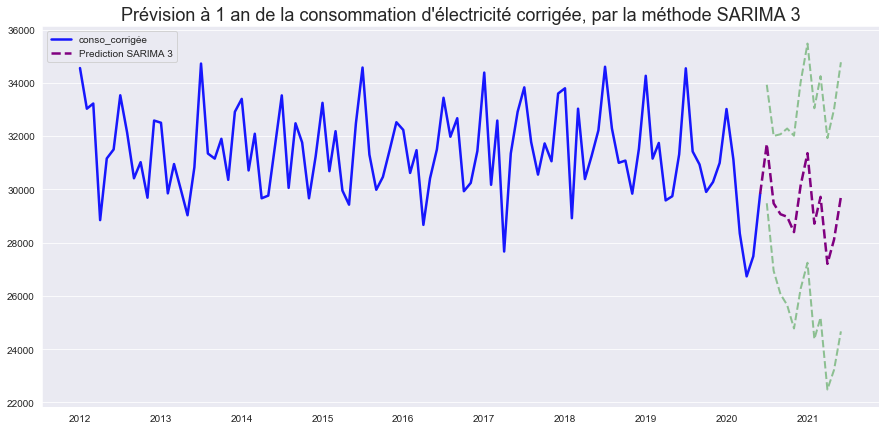

In [56]:
#affichage prévision
fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev_sarima3.mask(data_prev_sarima3.apply(lambda x: x.index > '2020-06-01'))[0], label='conso_corrigée', c = 'b', lw= 2.5, alpha = 0.9)
plt.plot(data_prev_sarima3.mask(data_prev_sarima3.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction SARIMA 3', c = 'purple', lw= 2.5, ls = 'dashed')
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_l_3, color='g', lw= 2, ls = 'dashed', alpha = 0.4)
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_u_3, color='g', lw= 2, ls = 'dashed', alpha = 0.4)
ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision à 1 an de la consommation d\'électricité corrigée, par la méthode SARIMA 3', size = 18)
plt.show()

## Algorithme pour identifier les paramètres optimaux via minimisation de l'AIC 

In [57]:
#Algorithme "Grid Search"
#generation des tuples de parametres sarima possibles
modeles = list() #liste des modeles à tester
#definition des paramètres possibles pour le modele
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
s_params = [12]

# boucle pour lister les modeles possibles
for p in p_params:
    for d in d_params:
        for q in q_params:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                        for s in s_params:
                            parametres = [(p,d,q), (P,D,Q,s)]
                            modeles.append(parametres)           
#modelisation pour chaque configuration et recuperation de l'AIC
modeles_aic = list()
for elt in modeles:
    model = SARIMAX(conso_corrigée, order=elt[0], seasonal_order=elt[1], initialization='approximate_diffuse')
    results = model.fit()
    
    #coefficients tous significatifs
    if any(i > 0.05 for i in results.pvalues):
        modeles_aic.append(np.nan)
        continue
        
    modeles_aic.append(results.aic)
    print(elt,' modélisé.')

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[(0, 0, 0), (0, 0, 1, 12)]  modélisé.
[(0, 0, 0), (0, 1, 0, 12)]  modélisé.
[(0, 0, 0), (1, 0, 0, 12)]  modélisé.
[(0, 0, 0), (1, 1, 0, 12)]  modélisé.
[(0, 0, 0), (1, 1, 1, 12)]  modélisé.
[(0, 0, 0), (2, 0, 0, 12)]  modélisé.
[(0, 0, 0), (2, 0, 1, 12)]  modélisé.
[(0, 0, 1), (0, 0, 0, 12)]  modélisé.
[(0, 0, 1), (0, 0, 1, 12)]  modélisé.
[(0, 0, 1), (0, 1, 0, 12)]  modélisé.
[(0, 0, 1), (1, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(0, 0, 1), (1, 1, 1, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(0, 0, 1), (2, 0, 1, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(0, 0, 2), (0, 0, 1, 12)]  modélisé.
[(0, 0, 2), (0, 1, 0, 12)]  modélisé.
[(0, 0, 2), (1, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

[(0, 1, 0), (0, 0, 0, 12)]  modélisé.
[(0, 1, 0), (0, 0, 1, 12)]  modélisé.
[(0, 1, 0), (0, 0, 2, 12)]  modélisé.
[(0, 1, 0), (0, 1, 0, 12)]  modélisé.
[(0, 1, 0), (0, 1, 1, 12)]  modélisé.
[(0, 1, 0), (0, 1, 2, 12)]  modélisé.
[(0, 1, 0), (1, 0, 0, 12)]  modélisé.
[(0, 1, 0), (1, 0, 1, 12)]  modélisé.
[(0, 1, 0), (1, 1, 0, 12)]  modélisé.
[(0, 1, 0), (1, 1, 1, 12)]  modélisé.
[(0, 1, 0), (1, 1, 2, 12)]  modélisé.
[(0, 1, 0), (2, 0, 0, 12)]  modélisé.
[(0, 1, 0), (2, 0, 1, 12)]  modélisé.
[(0, 1, 0), (2, 1, 0, 12)]  modélisé.
[(0, 1, 0), (2, 1, 1, 12)]  modélisé.
[(0, 1, 0), (2, 1, 2, 12)]  modélisé.
[(0, 1, 1), (0, 0, 0, 12)]  modélisé.
[(0, 1, 1), (0, 0, 2, 12)]  modélisé.
[(0, 1, 1), (0, 1, 0, 12)]  modélisé.
[(0, 1, 1), (1, 0, 0, 12)]  modélisé.
[(0, 1, 1), (1, 0, 1, 12)]  modélisé.
[(0, 1, 1), (1, 1, 0, 12)]  modélisé.
[(0, 1, 1), (1, 1, 1, 12)]  modélisé.
[(0, 1, 1), (2, 0, 0, 12)]  modélisé.
[(0, 1, 1), (2, 1, 0, 12)]  modélisé.
[(0, 1, 1), (2, 1, 1, 12)]  modélisé.
[(0, 1, 1), 

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[(0, 1, 2), (0, 1, 0, 12)]  modélisé.
[(0, 1, 2), (1, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 0), (0, 0, 0, 12)]  modélisé.
[(1, 0, 0), (0, 0, 1, 12)]  modélisé.
[(1, 0, 0), (0, 0, 2, 12)]  modélisé.
[(1, 0, 0), (0, 1, 0, 12)]  modélisé.
[(1, 0, 0), (1, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 0), (1, 1, 0, 12)]  modélisé.
[(1, 0, 0), (1, 1, 1, 12)]  modélisé.
[(1, 0, 0), (1, 1, 2, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 0), (2, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 0), (2, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 0), (2, 1, 1, 12)]  modélisé.
[(1, 0, 0), (2, 1, 2, 12)]  modélisé.
[(1, 0, 1), (0, 0, 0, 12)]  modélisé.
[(1, 0, 1), (0, 0, 1, 12)]  modélisé.
[(1, 0, 1), (0, 0, 2, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (1, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (1, 1, 2, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (2, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (2, 1, 1, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 2), (0, 0, 1, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 2), (0, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

[(1, 1, 0), (0, 0, 0, 12)]  modélisé.
[(1, 1, 0), (0, 0, 1, 12)]  modélisé.
[(1, 1, 0), (0, 0, 2, 12)]  modélisé.
[(1, 1, 0), (0, 1, 0, 12)]  modélisé.
[(1, 1, 0), (0, 1, 1, 12)]  modélisé.
[(1, 1, 0), (1, 0, 0, 12)]  modélisé.
[(1, 1, 0), (1, 1, 0, 12)]  modélisé.
[(1, 1, 0), (1, 1, 1, 12)]  modélisé.
[(1, 1, 0), (2, 0, 0, 12)]  modélisé.
[(1, 1, 0), (2, 0, 1, 12)]  modélisé.
[(1, 1, 0), (2, 1, 0, 12)]  modélisé.
[(1, 1, 0), (2, 1, 1, 12)]  modélisé.
[(1, 1, 0), (2, 1, 2, 12)]  modélisé.
[(1, 1, 1), (0, 1, 0, 12)]  modélisé.
[(1, 1, 1), (1, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 1, 1), (2, 1, 0, 12)]  modélisé.
[(1, 1, 2), (0, 0, 0, 12)]  modélisé.
[(1, 1, 2), (0, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 1, 2), (1, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 0, 0), (0, 0, 0, 12)]  modélisé.
[(2, 0, 0), (1, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 0, 0), (1, 1, 0, 12)]  modélisé.
[(2, 0, 0), (1, 1, 2, 12)]  modélisé.
[(2, 0, 0), (2, 0, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 0, 0), (2, 1, 1, 12)]  modélisé.
[(2, 0, 0), (2, 1, 2, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 0, 1), (0, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 0, 1), (1, 1, 0, 12)]  modélisé.
[(2, 0, 1), (1, 1, 1, 12)]  modélisé.
[(2, 0, 1), (1, 1, 2, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 0, 1), (2, 1, 1, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

[(2, 1, 2), (0, 1, 0, 12)]  modélisé.
[(2, 1, 2), (0, 1, 1, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 1, 2), (1, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 1, 2), (2, 1, 0, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(2, 1, 2), (2, 1, 1, 12)]  modélisé.


C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
#classement, recuperation des 3 modeles avec l'AIC le plus faible
liste_modeles = pd.DataFrame({'modele': modeles, 'AIC': modeles_aic}).sort_values(by = 'AIC', na_position = 'last')
modeles_top3 = liste_modeles[:3]
modeles_top3

,modele,AIC
89,"[(0, 1, 1), (2, 1, 2, 12)]",2241.512267
322,"[(2, 1, 2), (2, 1, 1, 12)]",2246.317306
321,"[(2, 1, 2), (2, 1, 0, 12)]",2248.209513


In [59]:
#prevision avec le modele de l'algorithme

model_algo = SARIMAX(conso_corrigée, order=(0,1,1), seasonal_order=(2,1,2,12))
results_algo = model_algo.fit()

pred_model_algo = results_algo.get_forecast(12)
pred_algo = pred_model_algo.predicted_mean

#intervalle de confiance
conf_int = pred_model_algo.conf_int(alpha=0.05)
pred_l = conf_int.iloc[:,0] #borne inf intervalle de confiance
pred_u = conf_int.iloc[:,1] #borne sup intervalle de confiance

#creation d'un df regroupant une seule série avec la conso et la prévision

last_date = data.index[len(data)-1] 
last_date = datetime.date(last_date.year, last_date.month + 1, last_date.day) #dernière date des données / début prevision
date_predict = datetime.date(last_date.year + 1, last_date.month - 1, last_date.day) # date de fin de la prevision

data_prev_sarima_algo = pd.DataFrame(index = pd.date_range(last_date, date_predict , freq='MS'), data = pred)
data_prev_sarima_algo = pd.concat([data['conso_corrigée'], data_prev_sarima_algo])

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


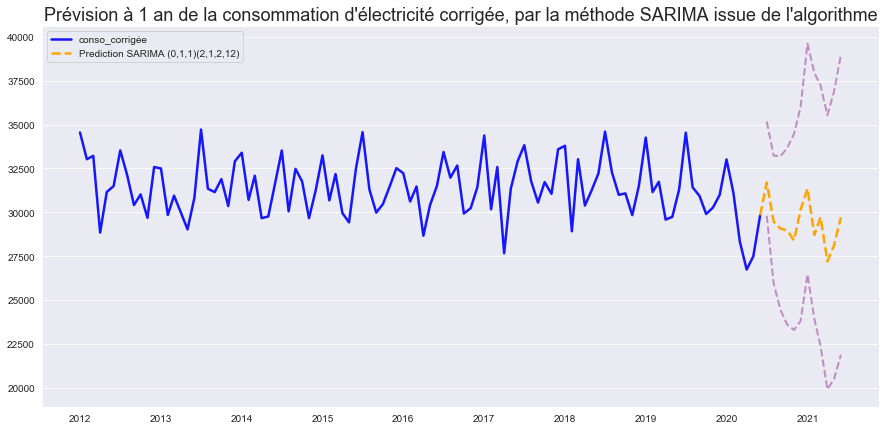

In [60]:
#affichage prévision
fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev_sarima_algo.mask(data_prev_sarima_algo.apply(lambda x: x.index > '2020-06-01'))[0], label='conso_corrigée', c = 'b', lw= 2.5, alpha = 0.9)
plt.plot(data_prev_sarima_algo.mask(data_prev_sarima_algo.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction SARIMA (0,1,1)(2,1,2,12)', c = 'orange', lw= 2.5, ls = 'dashed')
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_l, color='purple', lw= 2, ls = 'dashed', alpha = 0.4)
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_u, color='purple', lw= 2, ls = 'dashed', alpha = 0.4)
ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision à 1 an de la consommation d\'électricité corrigée, par la méthode SARIMA issue de l\'algorithme', size = 18)
plt.show()

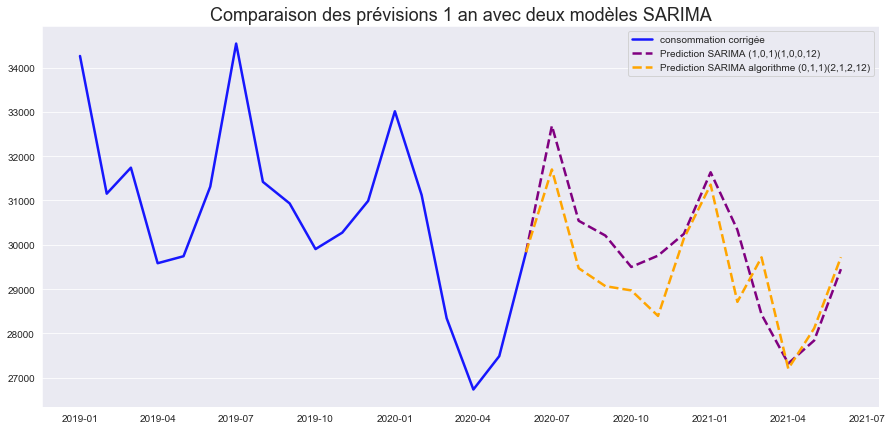

In [61]:
#comparaison entre les 2 sarima
fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(data_prev[-30:-12][0], c = 'b', lw= 2.5, alpha = 0.9, label='consommation corrigée')
plt.plot(data_prev_sarima.mask(data_prev_sarima.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction SARIMA (1,0,1)(1,0,0,12)', c = 'purple', lw= 2.5, ls = 'dashed')
plt.plot(data_prev_sarima_algo.mask(data_prev_sarima_algo.apply(lambda x: x.index < '2020-06-01'))[0],label='Prediction SARIMA algorithme (0,1,1)(2,1,2,12)', c = 'orange', lw= 2.5, ls = 'dashed')
ax1.xaxis.grid(False)
plt.legend()
plt.title('Comparaison des prévisions 1 an avec deux modèles SARIMA', size = 18)
plt.show()

## ANALYSE A POSTERIORI SUR LES 3 MEILLEURS MODELES

In [62]:
#split des données : train et test
conso_train = conso_corrigée[conso_corrigée.index < '2019-01-01']
conso_a_prevoir = conso_corrigée[conso_corrigée.index >= '2019-01-01']

#calcul du RMSE et du MAPE pour les 3 modeles
modeles_rmse = list()
modeles_mape = list()
modeles_predictions = list()

for elt in modeles_top3['modele']:
    model = SARIMAX(conso_train, order=elt[0], seasonal_order=elt[1])
    results = model.fit()
    #prediction
    model_pred = results.get_forecast(len(conso_a_prevoir))
    model_pred = model_pred.predicted_mean
    #RMSE
    rmse = np.sqrt(((conso_a_prevoir-model_pred)**2).mean())
    modeles_rmse.append(rmse)
    #MAPE
    mape=(np.abs(1-model_pred/conso_a_prevoir)).mean()*100
    modeles_mape.append(mape)
    
modeles_top3['RMSE'] = modeles_rmse
modeles_top3['MAPE'] = modeles_mape

modeles_top3

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\artba\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to 

,modele,AIC,RMSE,MAPE
89,"[(0, 1, 1), (2, 1, 2, 12)]",2241.512267,1355.237024,3.389012
322,"[(2, 1, 2), (2, 1, 1, 12)]",2246.317306,2253.892694,6.252682
321,"[(2, 1, 2), (2, 1, 0, 12)]",2248.209513,1779.728251,4.499688


- L'analyse a posteriori confirme que le meilleur modèle semble être le $SARIMA(0,1,1)(2,1,2)_{12}$

### Vérification de la validité du modèle final

In [70]:
#affichage summary du modele choisi (sur la série train)
model_final = SARIMAX(conso_train, order=(0,1,1), seasonal_order=(2,1,2,12))
results = model_final.fit()
model_final_pred = results.get_forecast(len(conso_a_prevoir))
model_final_pred = model_final_pred.predicted_mean

print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -617.792
Date:                                 Mon, 09 Nov 2020   AIC                           1247.585
Time:                                         09:45:27   BIC                           1261.161
Sample:                                     01-01-2012   HQIC                          1252.984
                                          - 12-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0758      0.040     -1.899      0.058      -0.154       0

C:\Users\artba\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [71]:
#Nouveau modele en retirant les parametres non-significatifs 
model_final_2 = SARIMAX(conso_train, order=(0,1,1), seasonal_order=(1,1,2,12))
results2 = model_final_2.fit()

#prevision 
model_final_pred2 = results2.get_forecast(len(conso_a_prevoir))

#intervalle de confiance
conf_int = model_final_pred2.conf_int(alpha=0.1)
pred_l = conf_int.iloc[:,0] #borne inf intervalle de confiance
pred_u = conf_int.iloc[:,1] #borne sup intervalle de confiance

model_final_pred2 = model_final_pred2.predicted_mean

print(results2.summary())

print('\n\n\n Retard : p-value Ljungbox')
for elt in [6, 12, 18, 24, 30, 36]:
    print('   {}    :    {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt, return_df = False)[1].mean()))

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -617.817
Date:                                 Mon, 09 Nov 2020   AIC                           1245.635
Time:                                         09:59:51   BIC                           1256.948
Sample:                                     01-01-2012   HQIC                          1250.134
                                          - 12-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0794      0.039     -2.044      0.041      -0.156      -0

In [65]:
#calcul du modele intialement choisi (avant algorithme) sur la série tronquée
model_B = SARIMAX(conso_train, order=(1,0,1), seasonal_order=(1,0,0,12))
results_B = model_B.fit()
model_B_pred = results_B.get_forecast(len(conso_a_prevoir))
model_B_pred = model_B_pred.predicted_mean


print('RMSE modele B: ',np.sqrt(((conso_a_prevoir-model_B_pred)**2).mean()))
print('RMSE modele 2 algo: ',np.sqrt(((conso_a_prevoir-model_final_pred2)**2).mean()))

RMSE modele B:  1988.1284148083603
RMSE modele 2 algo:  1382.5417552695546


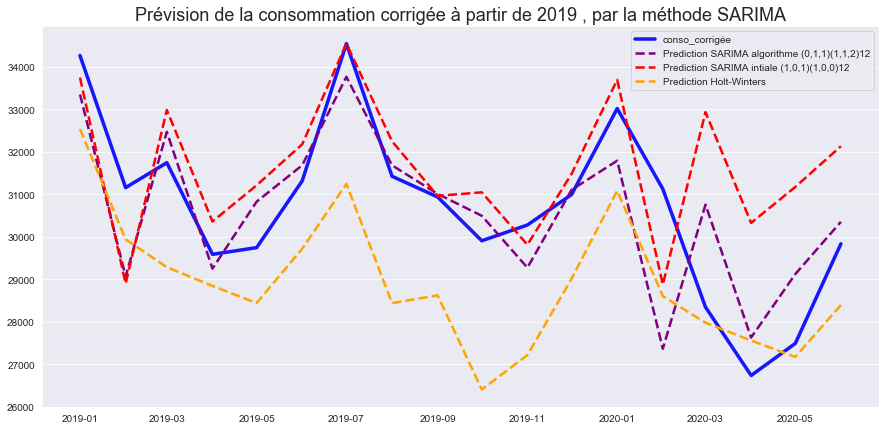

In [66]:
# Plot de comparaison des 2 modèles (modele initial, modele issu de l'algorithme, + modele Holt-Walters)

last_date = conso_train.index[len(conso_train)-1] 
last_date = datetime.date(last_date.year + 1, last_date.month -11 , last_date.day) #dernière date des données / début prevision
date_predict = datetime.date(last_date.year + 1, last_date.month +5, last_date.day) # date de fin de la prevision

data_prev_sarima = pd.DataFrame(index = pd.date_range(last_date, date_predict , freq='MS'), data = model_final_pred)
data_prev_sarima = pd.concat([conso_train, data_prev_sarima])

data_prev_sarima2 = pd.DataFrame(index = pd.date_range(last_date, date_predict , freq='MS'), data = model_final_pred2)
data_prev_sarima2 = pd.concat([conso_train, data_prev_sarima2])

data_prev_sarimaB = pd.DataFrame(index = pd.date_range(last_date, date_predict , freq='MS'), data = model_B_pred)
data_prev_sarimaB = pd.concat([conso_train, data_prev_sarimaB])


fig, ax1 = plt.subplots(figsize=(15,7))

#conso
plt.plot(conso_corrigée[conso_corrigée.index >= '2019-01-01'], label='conso_corrigée', c = 'b', lw= 3.5, alpha = 0.9)

#SARIMA algorithme
plt.plot(data_prev_sarima2.mask(data_prev_sarima2.apply(lambda x: x.index < '2019-01-01'))[0],label='Prediction SARIMA algorithme (0,1,1)(1,1,2)12', c = 'purple', lw= 2.5, ls = 'dashed')
#SARIMA initial
plt.plot(data_prev_sarimaB.mask(data_prev_sarimaB.apply(lambda x: x.index < '2019-01-01'))[0], label='Prediction SARIMA intiale (1,0,1)(1,0,0)12', c = 'red', lw= 2.5, ls = 'dashed')
#HW
plt.plot(data_prev3.mask(data_prev3.apply(lambda x: x.index < '2019-01-01'))[0],label='Prediction Holt-Winters', c = 'orange', lw= 2.5, ls = 'dashed')

ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision de la consommation corrigée à partir de 2019 , par la méthode SARIMA', size = 18)
plt.savefig('P9_02_graphiques/graph_Q3_comparaisons.png', bbox_inches='tight')
plt.show()

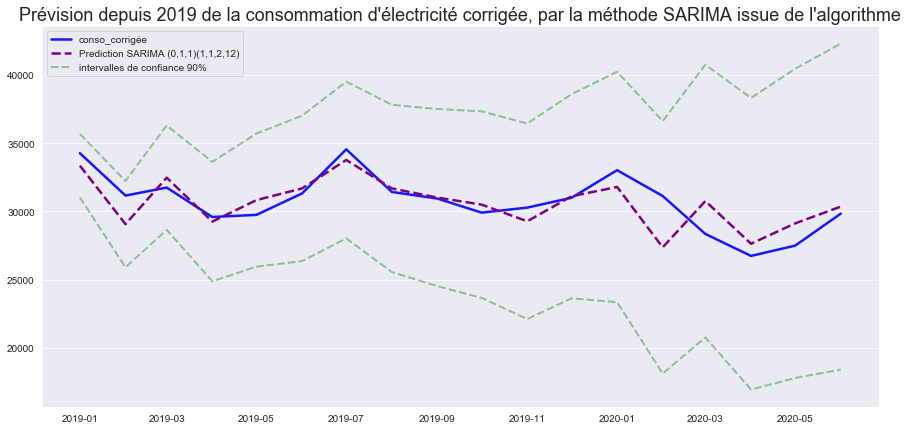

In [67]:
#affichage prévision SARIMA algorithme avec les intervalles de confiance

fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(conso_corrigée[conso_corrigée.index >= '2019-01-01'], label='conso_corrigée', c = 'b', lw= 2.5, alpha = 0.9)
plt.plot(data_prev_sarima2.mask(data_prev_sarima2.apply(lambda x: x.index < '2019-01-01'))[0],label='Prediction SARIMA (0,1,1)(1,1,2,12)', c = 'purple', lw= 2.5, ls = 'dashed')
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_l, color='green', lw= 2, ls = 'dashed', alpha = 0.4, label='intervalles de confiance 90%')
plt.plot(pd.date_range(last_date, date_predict , freq='MS'), pred_u, color='green', lw= 2, ls = 'dashed', alpha = 0.4)
ax1.xaxis.grid(False)
plt.legend()
plt.title('Prévision depuis 2019 de la consommation d\'électricité corrigée, par la méthode SARIMA issue de l\'algorithme', size = 18)
plt.show()